In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import torch
from torch import nn

from utils import flat_to_triangular, make_cholesky, plot

np.random.seed(3)

### $D$-dimensional features, scalar regression target, with covariance

### Problem

We consider a regression problem with $D$-dimensional features $\mathbf{x}$, scalar targets $\mathbf{t}$ and unknown variance $\sigma^2$. We wish to learn a bayesian linear model with learnt basis functions. 

### Case of the known basis function

In the case of a known deterministic $D$-dimensional basis function $\phi$, the likelihood of a data point $(x_i, t_i)$ is:

\begin{align}
p(t_i \ |\ \mathbf{a}, b, x_i; \sigma^2) & = \mathcal{N}(\mathbf{a} \phi(x_i) + b, \sigma^2) 
\end{align}

We define the prior over the parameters as an isotropic Gaussian:

\begin{align}
 p(\mathbf{a}) = \mathcal{N}(0,\mathbf{I}) \qquad  p(b) = \mathcal{N}(0,1)
\end{align}

The posterior of the parameters, with $(\mathbf{x}, \mathbf{t})$ the entire dataset, is:

\begin{align}
p(\mathbf{a},b \ |\ \mathbf{t} , \mathbf{x}; \sigma^2) = \frac{p(\mathbf{t} \ |\  \mathbf{a}, b, \mathbf{x}; \sigma^2) p(\mathbf{a},b)}{p(\mathbf{t}\ |\ \mathbf{x}; \sigma^2)}
\end{align}

The denominator $p(\mathbf{t} \ |\ \mathbf{x}; \sigma^2)$ is tractable and constant, hence we can also approximate the posterior using our favorite MCMC methods.


### Learnt basis function

#### Bayes by Backprop

Let $\mathbf{w}$ be the vector with all the parameters $\mathbf{a}$ and $b$, having size $D' = D+1$. As basis function we use $f_\theta$, a neural network parameterized by a vector $\theta$. This effectively corresponds to a neural network where the last layer is Bayesian.

We approximate the posterior parameter distribution $p(\mathbf{w} \ |\ \mathcal{D})$ with

$$q(\mathbf{w}) = \mathcal{N}(\boldsymbol{\mu}_{\mathbf{w}}, \boldsymbol{\Sigma}_{\mathbf{w}})$$

and optimize this distribution with variational inference, whereas $\theta$ and $\sigma^2$ are estimated by maximum likelihood. We do this by deriving a lower bound of the marginal log likelihood that we can optimize end-to-end with respect to $\theta$, $\sigma^2$, $\boldsymbol{\mu}_{\mathbf{w}}$, and $ \boldsymbol{\Sigma}_{\mathbf{w}}$. We have:

\begin{align}
\log p(\mathbf{t} | \mathbf{x};\theta) & = \log \int_{\mathbf{a},b} p(\mathbf{t}, \mathbf{a}, b | \mathbf{x};  \theta) d\mathbf{a} db \\
& = \log \int_{\mathbf{a},b} p(\mathbf{t} | \mathbf{a}, b, \mathbf{x};  \theta)p(\mathbf{a},b) d\mathbf{a} d\mathbf{b} \\
& = \log \int_{\mathbf{a},b} q(\mathbf{a},b) p(\mathbf{t} | \mathbf{a}, b, \mathbf{x};  \theta) \frac{p(\mathbf{a},b)}{q(\mathbf{a},b)} d\mathbf{a} db \\
& \geq \mathbb{E}_{q(\mathbf{a},b)} \left[ \log  p(\mathbf{t} | \mathbf{a},b, \mathbf{x}; \theta) \frac{p(\mathbf{a},b)}{q(\mathbf{a},b)} \right] \\
& = \mathbb{E}_q[\log p(\mathbf{t}\ |\ \mathbf{a},b, \mathbf{x}; \theta)] - \mathrm{KL}(q(\mathbf{a},b) \ ||\ p(\mathbf{a},b)) \\
&= \mathcal{L (\mathbf{t},\mathbf{x})}
\end{align}

#### Modelling the posterior of vector quantities with covariance

We choose to model the approximate posterior of $\mathbf{w}$ using a **Multivariate Gaussian** where the covariance matrix $\boldsymbol{\Sigma}$ is parametrized by using the Cholesky decomposition $\boldsymbol{\Sigma}=\mathbf{L}\mathbf{L}^T$, which allows us to apply the reparametrization trick [[Pathwise Derivatives Beyond the Reparameterization Trick]](https://arxiv.org/pdf/1806.01851.pdf):

\begin{align}
\mathbf{w} = \boldsymbol{\mu} + \mathbf{L} \boldsymbol{\epsilon}, \quad 
\boldsymbol{\epsilon} \sim \mathcal{N}(0, \mathbf{I}) \quad \Rightarrow \quad
\mathbf{w} \sim \mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\Sigma})
\end{align}

where we can easily see that the mean of $\mathbf{w}$ is $\boldsymbol{\mu}$, and the covariance is indeed $\boldsymbol{\Sigma}$:

\begin{aligned}
\mathrm{cov} (\mathbf{w}) &=\mathbb{E}\left[(\mathbf{w}-\mathbb{E}[\mathbf{w} ])(\mathbf{w}-\mathbb{E}[\mathbf{w} ])^{T}\right] \\ 
&=\mathbb{E}\left[\mathbf{L} \boldsymbol{\epsilon}(\mathbf{L} \boldsymbol{\epsilon})^{T}\right] \\ 
&=\mathbb{E}\left[\mathbf{L} \boldsymbol{\epsilon} \boldsymbol{\epsilon}^{T} \mathbf{L}^{T}\right] \\ 
&=\mathbf{L} \mathbb{E}\left[\boldsymbol{\epsilon} \boldsymbol{\epsilon}^{T}\right] \mathbf{L}^{T} \\ 
&=\mathbf{L} \mathbf{L}^{T} = \boldsymbol{\Sigma}
\end{aligned}


The two terms we need to compute the ELBO are as follows:

\begin{split}
\mathbb{E}_q[\log p(\mathbf{t}\ |\ \mathbf{a}, b, \mathbf{x} ; \theta, \sigma^2)] &=  \mathbb{E}_q \left[ \sum_{i = 1}^N \left[ -\frac{1}{2} \log \sigma^2 - \frac{1}{2\sigma^2} [(t_i - \mathbf{a} f_{\theta}(x_i) - b)^2] + \mathrm{const.} \right] \right] \\
\mathrm{KL}(q(\mathbf{w}) \ ||\ p(\mathbf{w})) &= -\frac{1}{2} \sum_{i=1}^{D'} \left(1 + \log L_{i,i}^2 - \mu_i^2 - \Sigma_{i,i}\right)
\end{split}
where $N$ is the data set size.

Here we used the KL divergence between multivariate Gaussian distributions:
\begin{aligned}
\mathrm{KL}(q\ ||\ p))
    &= \frac{1}{2} \left( \log |\boldsymbol{\Sigma}_ p| - \log |\boldsymbol{\Sigma}_ q| - D' + \mathrm{tr} (\boldsymbol{\Sigma}_p^{-1} \boldsymbol{\Sigma}_q) + (\boldsymbol{\mu}_p - \boldsymbol{\mu}_q)^T  \boldsymbol{\Sigma}_p (\boldsymbol{\mu}_p - \boldsymbol{\mu}_q)\right) \\
    & = \frac{1}{2} \left( - \log \left(|\boldsymbol{L}|^2\right) - D' + \mathrm{tr} (\boldsymbol{\Sigma}_q) +  \boldsymbol{\mu}_q^T \boldsymbol{\mu}_q\right) \\
    & = -\frac{1}{2} \left(D' + \sum_{i=1}^{D'} \log L_{ii}^2 - \sum_{i=1}^{D'} (\boldsymbol{\Sigma}_q)_{ii} - \sum_{i=1}^{D'} \mu_i^2 \right)
\end{aligned}

### Papers

[Gaussian variational approximation with a factor covariance structure](https://arxiv.org/pdf/1701.03208.pdf)

[Pathwise Derivatives Beyond the Reparameterization Trick](https://arxiv.org/pdf/1806.01851.pdf)

[Berkley Kingma ppt](https://berkeley-deep-learning.github.io/cs294-131-s17/slides/VAE%20talk.compressed.pdf)

### Toy Dataset 1

f shape: (40, 3)
a shape: (3, 1)


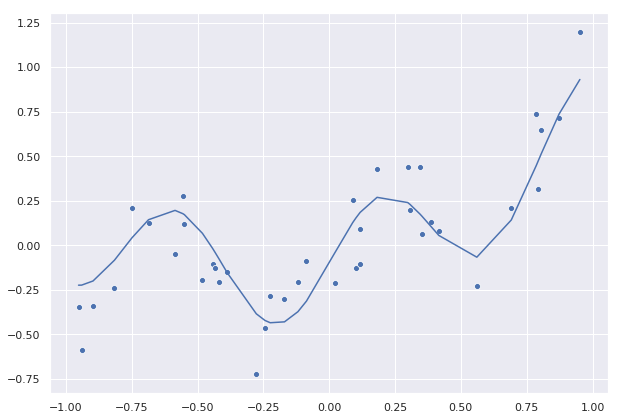

In [2]:
N = 40
true_a = np.array([.3, .5, .3]).reshape(-1, 1)
true_b = np.asarray(0.2)
sigma = 0.15  # observation noise
# x = np.linspace(-1, 1, N).reshape(-1, 1)
x = (np.random.rand(N) * 2 - 1).reshape(-1, 1)
x.sort(axis=0)
fx1 = x - 1
fx2 = x**2
fx3 = np.sin(8 * x)
fx = np.concatenate((fx1, fx2, fx3), axis=-1)
print('f shape:', fx.shape)
print('a shape:', true_a.shape)
t = fx @ true_a + true_b + sigma*np.random.randn(*x.shape)  # observations
plt.figure(figsize=(10, 7))
plt.plot(x, fx @ true_a + true_b)
# plt.plot(x, fx, alpha=0.3)
sns.scatterplot(x[:, 0], t[:, 0])
plt.show() 

x = torch.tensor(x, dtype=torch.float)
t = torch.tensor(t, dtype=torch.float)

### Features extractor and stochastic layer

Define function $f_{\theta}$ to extract features $h = f_{\theta}(x)$, with parameters $\theta$ to be optimized.

The stochastic layer has no state, it's only used to get samples from $\mathcal{N}(\mu, \sigma^2)$, and to compute the KL divergence from a prior $\mathcal{N}(0, 1)$ to a variational distribution $q = \mathcal{N}(\mu, \sigma^2)$.

In [3]:
class FeaturesExtractor(nn.Module):
    def __init__(self, n_out):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 32), nn.ReLU(),
            nn.Linear(32, n_out))
        
    def forward(self, x):
        return self.layers(x)
    
    
class CovarianceStochasticLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, mu_q, cholesky):
        eps = torch.randn_like(mu_q)
        return mu_q + cholesky @ eps
    
    def forward_diagonal(self, mu_q, logvar_q):
        eps = torch.randn_like(mu_q)
        std = (logvar_q/2).exp()
        return mu_q + std * eps

    def get_kl(self, mu_q, L_logdiag_q, L_q):
        kl = -0.5 * (1 + L_logdiag_q - mu_q.pow(2) - torch.diag(L_q @ L_q.permute(1, 0)))
        #print(L_logdiag_q.sum().item(), mu_q.pow(2).sum().item(), torch.diag(L_q @ L_q.permute(1, 0)).sum().item())
        return kl.sum()


### Optimize

Here we maximize the ELBO $\mathcal{L}$ with respect to variational parameters, the NN parameters $\theta$, and the noise std $\sigma$.

In [4]:
features = FeaturesExtractor(n_out=true_a.shape[0])   # TODO use any n_out, not fixed to true parameter size
stochastic = CovarianceStochasticLayer()
l_rate = 0.01
epochs = 10000
n_samples = 5  # MC samples per example
n_parameters = true_a.size + true_b.size
mu_ab = nn.Parameter(torch.zeros((n_parameters)))  # for a and b

# diagonal covariance
logvar_ab = nn.Parameter(torch.zeros((n_parameters)))

# off-diagonal covariance
cov_ab_params = nn.Parameter(torch.zeros((n_parameters*(n_parameters-1)//2)).normal_() * 0.0)

logvar = nn.Parameter(torch.tensor(0.))  # for noise
optimiser = torch.optim.Adam(list(features.parameters()) + [mu_ab, logvar_ab, logvar, cov_ab_params], lr = l_rate)

for epoch in range(epochs):
    optimiser.zero_grad()
    h = features(x)
    cov_ab = flat_to_triangular(cov_ab_params)
    L = make_cholesky(logvar_ab, cov_ab)
    elbo = torch.zeros((n_samples), device=x.device)
    for i in range(n_samples):
        ## Sample once from q(a) q(b)
        ab_sample = stochastic(mu_ab, L)
        a, b = ab_sample[:-1], ab_sample[-1:]
        a = a.unsqueeze(1)
        
        y = h @ a + b  # stochasticity here only comes from a and b
        expected_mse_i = (t - y)**2
    
        ## Reconstruction loss, estimated by MC
        recons_i = (0.5/logvar.exp() * expected_mse_i + 0.5*logvar)  # recons per example
    
        ## KL loss, both analytic and by MC
        #kl_estimate = 0.5*expected_kl_term - 0.5*logvar_ab.sum()
        kl_i = stochastic.get_kl(mu_ab, logvar_ab, L)
        #kl = (a**2).sum() + b**2 - ((a - mu_a)**2/logvar_a.exp()).sum() - (b - mu_b)**2/logvar_b.exp()
        #print(kl.shape)
    
        elbo[i] = - recons_i.sum() - kl_i
        
    # IW averaging
    elbo = elbo.mean() # log_sum_exp(elbo, dim=0, sum_op=torch.mean)
    
    loss = - elbo
    loss.backward()
    optimiser.step()
    if epoch % 250 == 0 or epoch == epochs-1:
        print(f'epoch {epoch} : loss {loss.data.item():.3f} ELBO {elbo.data.item():.3f}  Reconstruction {recons_i.sum().data.item()}  KL {kl_i.sum().data.item()}')
        

epoch 0 : loss 17.241 ELBO -17.241  Reconstruction 17.216463088989258  KL 0.0
epoch 250 : loss -5.463 ELBO 5.463  Reconstruction -11.648427963256836  KL 0.6667194366455078
epoch 500 : loss -18.564 ELBO 18.564  Reconstruction -29.07130241394043  KL 2.5870649814605713
epoch 750 : loss -28.632 ELBO 28.632  Reconstruction -37.25797653198242  KL 3.6735801696777344
epoch 1000 : loss -36.153 ELBO 36.153  Reconstruction -40.11020278930664  KL 4.32829475402832
epoch 1250 : loss -38.509 ELBO 38.509  Reconstruction -43.2496337890625  KL 4.782003402709961
epoch 1500 : loss -39.925 ELBO 39.925  Reconstruction -46.84856033325195  KL 5.263057708740234
epoch 1750 : loss -42.138 ELBO 42.138  Reconstruction -41.28120040893555  KL 5.7436676025390625
epoch 2000 : loss -47.239 ELBO 47.239  Reconstruction -53.42864990234375  KL 6.278749942779541
epoch 2250 : loss -48.620 ELBO 48.620  Reconstruction -54.74900817871094  KL 6.353659152984619
epoch 2500 : loss -51.838 ELBO 51.838  Reconstruction -58.93676757812

### Visualization

First we sample $a,b \sim q(a,b)$ according to the learned variational parameters. Get $N$ samples $a_i$ and $b_i$. Then sample from predictive distribution
$$t_i = a_i f_{\theta}(x_i) + b_i + \sigma \epsilon_i$$
with $\epsilon_i$ iid samples from $\mathcal{N}(0,1)$.

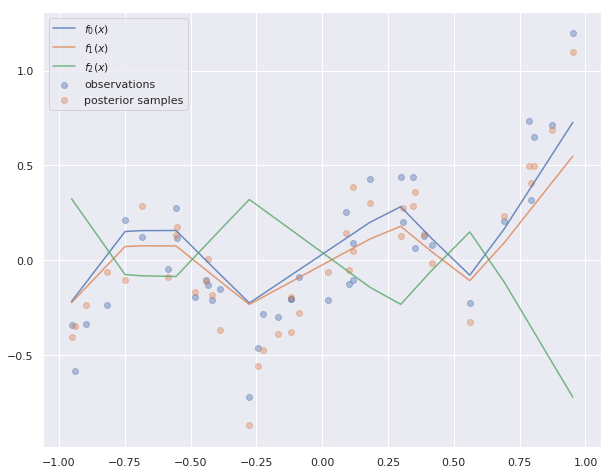

In [5]:
# Sample a, b ~ q(a, b)
n_samples = t.shape[0]
v = [stochastic(mu_ab, make_cholesky(logvar_ab, cov_ab)) for _ in range(n_samples)]
v = torch.cat([vv[None, :] for vv in v],0)
a, b = ab_sample[:-1], ab_sample[-1:]
a = a.unsqueeze(1)

a = a.detach().cpu().numpy()
b = b.detach().cpu().numpy()

# plt.figure(figsize=(6, 6))
# plt.pcolor
# plt.scatter(a, b, s=5)
# plt.xlabel('a')
# plt.ylabel('b')
# plt.title('samples from q(a, b)')
# plt.gca().set_aspect('equal', 'datalim')  # equal aspect ratio
# plt.show()

# For each x_i, use samples a_i, b_i to compute predicted t_i
h_ = features(x).detach().numpy()
# Do weird shape stuff because now we have many samples of a and b (unlike during training)
post_samples = (np.expand_dims(h_, 1) @ a).flatten() + b.flatten() + (logvar/2).exp().detach().numpy() * np.random.randn(n_samples)
plt.figure(figsize=(10,8))
plt.scatter(x, t, alpha=0.4, label='observations')
plt.scatter(x, post_samples, alpha=0.4, label='posterior samples')
for i in range(h.shape[1]):
    plt.plot(x.numpy(), h_[:, i], alpha=0.8, label='$f_{}(x)$'.format(i))
# plt.plot(x.numpy(), p5.numpy(), '--', color=sns.color_palette()[1], label='95% posterior interval')
# plt.plot(x.numpy(), p95.numpy(), '--',color=sns.color_palette()[1])
plt.legend()
plt.show()

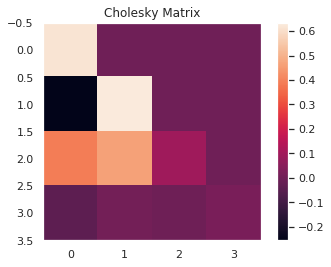

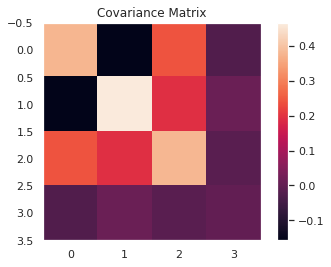

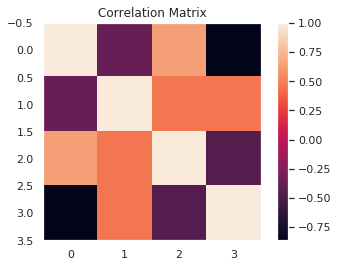

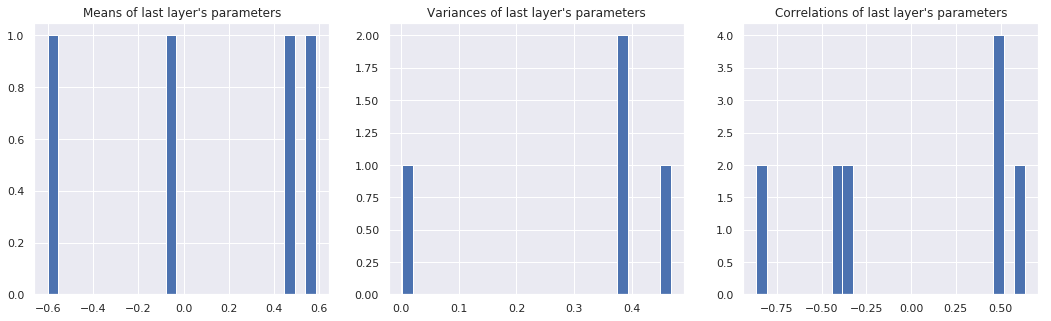

In [6]:
L = make_cholesky(logvar_ab, cov_ab).detach().cpu().numpy()
Cov = L @ L.T
inv_stds = np.diag(np.diag(Cov)**(-0.5))
Corr = inv_stds @ Cov @ inv_stds

plt.title("Cholesky Matrix"), plt.grid(False)
plt.imshow(L)
plt.colorbar()
plt.show()

plt.title("Covariance Matrix"), plt.grid(False)
plt.imshow(Cov)
plt.colorbar()
plt.show()

plt.title("Correlation Matrix"), plt.grid(False)
plt.imshow(Corr)
plt.colorbar()
plt.show()

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.title("Means of last layer's parameters")
plt.hist(mu_ab.detach(), bins=25)
plt.subplot(1, 3, 2)
plt.title("Variances of last layer's parameters")
plt.hist(np.diag(Cov), bins=25)
plt.subplot(1, 3, 3)
plt.title("Correlations of last layer's parameters")  # corr coefficients between pairs of DIFFERENT variables
correlations = Corr[~np.eye(Corr.shape[0], dtype=bool)]
plt.hist(correlations, bins=25)
plt.show()

estimated noise std: 0.137 - true std: 0.15
Sample parameters 3 times from their posterior, and each time generate predictions using random noise with estimated variance.


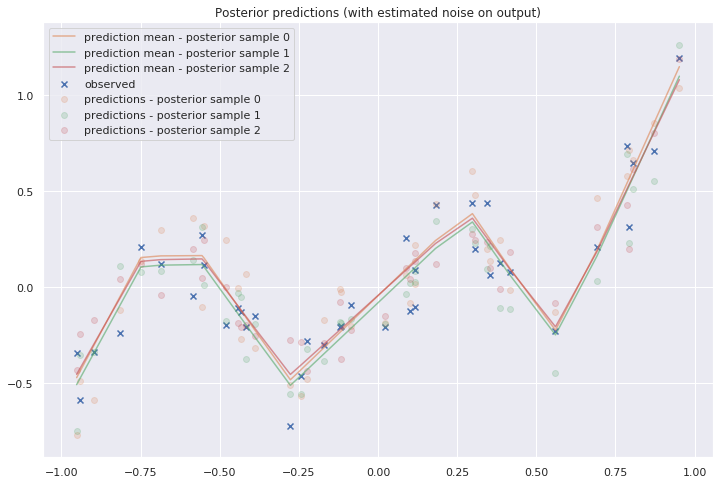

Posterior prediction mean 5000 samples from q(a, b):


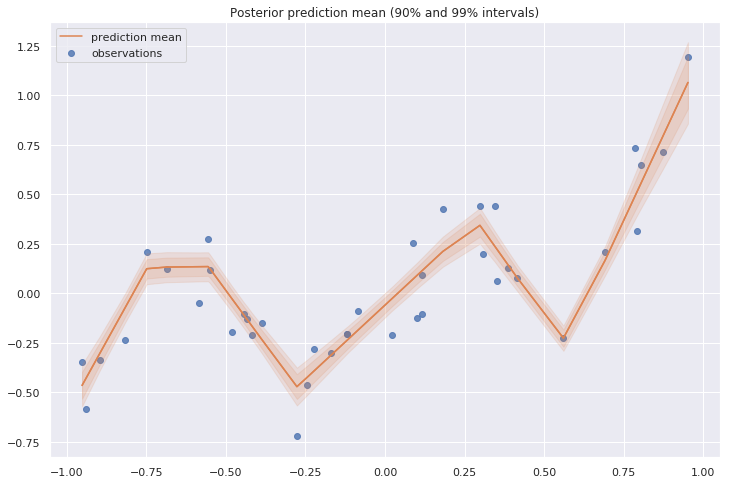

Sample parameters 5000 times from their posterior, and each time generate predictions on 100 equally spaced points using random noise with estimated variance.


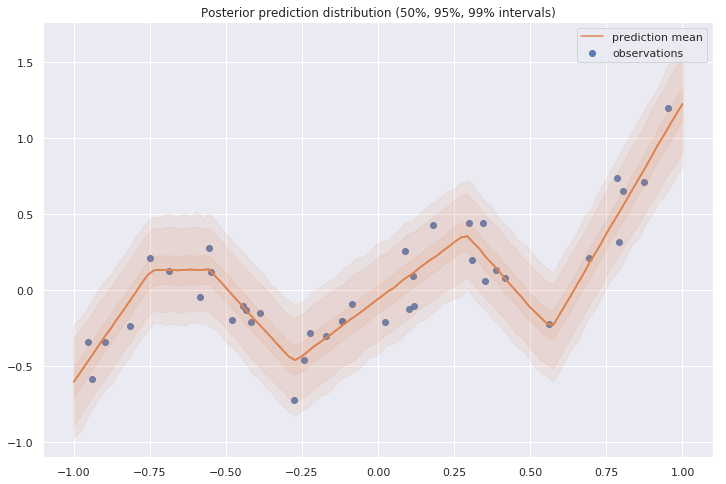

In [18]:
print('estimated noise std: {:.3g} - true std: {:.3g}'.format((logvar/2).exp().detach().numpy(), sigma))

n_samples = 3

print('Sample parameters {} times from their posterior, and each time generate predictions using random noise with estimated variance.'.format(n_samples))
plt.figure(figsize=(12, 8))
plt.title('Posterior predictions (with estimated noise on output)')
plt.scatter(x, t, marker='x', label='observed')
for s in range(n_samples):
    ab_sample = stochastic(mu_ab, make_cholesky(logvar_ab, cov_ab))
    a, b = ab_sample[:-1], ab_sample[-1:]
    a = a.unsqueeze(1)

    a = a.detach().cpu().numpy()
    b = b.detach().cpu().numpy()

    h_ = features(x).detach().numpy()   # shape (N, 3)
    post_samples_mean = h_ @ a + b
    post_samples = post_samples_mean + (logvar/2).exp().detach().numpy() * np.random.randn(*x.shape)
    plt.scatter(x, post_samples, alpha=0.2, label='predictions - posterior sample {}'.format(s), color=sns.color_palette()[s+1])
    plt.plot(x.detach().cpu().numpy(), post_samples_mean, alpha=0.6, label='prediction mean - posterior sample {}'.format(s), color=sns.color_palette()[s+1])

plt.legend()
plt.show()


plt.figure(figsize=(12, 8))
plt.title('Posterior distribution of output mean (noiseless)')
plt.scatter(x, t, alpha=0.8, label='observations')
n_samples = 5000
print("Posterior prediction mean {} samples from q(a, b):".format(n_samples))
post_samples_all = []
for s in range(n_samples):
    ab_sample = stochastic(mu_ab, make_cholesky(logvar_ab, cov_ab))
    a, b = ab_sample[:-1], ab_sample[-1:]
    a = a.unsqueeze(1)

    a = a.detach().cpu().numpy()
    b = b.detach().cpu().numpy()

    h_ = features(x).detach().numpy()   # shape (N, 3)
    post_samples = h_ @ a + b   # noiseless
    post_samples_all.append(post_samples[None, :, 0])

x_np = x.squeeze(-1).detach().cpu().numpy()
post_samples_all = np.concatenate(post_samples_all, axis=0)
post_samples_mean = np.mean(post_samples_all, axis=0)
post_samples_perc = np.percentile(post_samples_all, [0.5, 5, 95, 99.5], axis=0)
# plt.plot(x_np, post_samples_mean, alpha=0.3, label='noiseless prediction')
plot(x_np, post_samples_mean, y_lower=post_samples_perc[0], y_upper=post_samples_perc[-1], 
     alpha=0.15, label='prediction mean', color=sns.color_palette()[1])
plot(x_np, post_samples_mean, y_lower=post_samples_perc[1], y_upper=post_samples_perc[-2], 
     alpha=0.15, color=sns.color_palette()[1])
plt.title('Posterior prediction mean (90% and 99% intervals)')

plt.legend()
plt.show()



n_samples = 5000
n_points = 100
post_samples_all = []
print('Sample parameters {} times from their posterior, and each time generate predictions on {} equally spaced points using random noise with estimated variance.'.format(n_samples, n_points))
plt.figure(figsize=(12, 8))
x_ = np.linspace(-1, 1, n_points).reshape(-1, 1)
x_ = torch.tensor(x_).float()
for s in range(n_samples):
    ab_sample = stochastic(mu_ab, make_cholesky(logvar_ab, cov_ab))
    a, b = ab_sample[:-1], ab_sample[-1:]
    a = a.unsqueeze(1)

    a = a.detach().cpu().numpy()
    b = b.detach().cpu().numpy()

    h_ = features(x_).detach().numpy()   # shape (N, 3)
    post_samples_mean = h_ @ a + b
    post_samples = post_samples_mean + (logvar/2).exp().detach().numpy() * np.random.randn(*x_.shape)
    post_samples_all.append(post_samples[None, :, 0])

post_samples_all = np.concatenate(post_samples_all, axis=0)
post_samples_mean = np.mean(post_samples_all, axis=0)
post_samples_perc = np.percentile(post_samples_all, [0.5, 2.5, 25, 75, 97.5, 99.5], axis=0)
x_np_ = x_.squeeze(-1).detach().cpu().numpy()
plt.scatter(x, t, alpha=0.9, label='observations'.format(s))
plot(x_np_, post_samples_mean, y_lower=post_samples_perc[0], y_upper=post_samples_perc[-1], 
     alpha=0.1, label='prediction mean', color=sns.color_palette()[1])
plot(x_np_, post_samples_mean, y_lower=post_samples_perc[1], y_upper=post_samples_perc[-2], 
     alpha=0.1, color=sns.color_palette()[1])
plot(x_np_, post_samples_mean, y_lower=post_samples_perc[2], y_upper=post_samples_perc[-3], 
     alpha=0.1, color=sns.color_palette()[1])
plt.title('Posterior prediction distribution (50%, 95%, 99% intervals)')

plt.legend()
plt.show()